In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd

In [3]:
df = pd.read_csv('fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [5]:
num_classes = 7
width = 48
height = 48
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
classes=np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"))
df.Usage.value_counts() 

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [6]:
k = np.array(list(map(int,df.iloc[0,1].split(" "))),dtype='uint8').reshape((48,48))

In [7]:
k.shape

(48, 48)

In [8]:
X_train = []
y_train = []
X_test = []
y_test = []
for index, row in df.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        X_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        X_test.append(np.array(k))
        y_test.append(row['emotion'])

In [9]:
X_train[0]

array(['70', '80', '82', ..., '106', '109', '82'], dtype='<U3')

Neutral


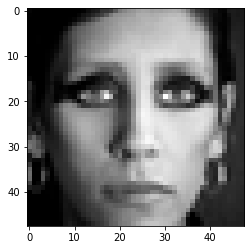

In [23]:
plt.imshow(np.array(X_train[4], dtype = 'uint8').reshape(48,48,1), cmap = 'gray')
print(emotion_labels[y_train[4]])

In [10]:
X_train = np.array(X_train, dtype = 'uint8')
y_train = np.array(y_train, dtype = 'uint8')
X_test = np.array(X_test, dtype = 'uint8')
y_test = np.array(y_test, dtype = 'uint8')

In [11]:
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

In [12]:
X_train.shape

(28709, 48, 48, 1)

In [13]:
from keras.utils import to_categorical
y_train= to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [14]:
from keras.preprocessing.image import ImageDataGenerator 
datagen = ImageDataGenerator( 
    rescale=1./255,
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest')

testgen = ImageDataGenerator( 
    rescale=1./255
    )
datagen.fit(X_train)
batch_size = 64

In [15]:
train_flow = datagen.flow(X_train, y_train, batch_size=batch_size) 
test_flow = testgen.flow(X_test, y_test, batch_size=batch_size)

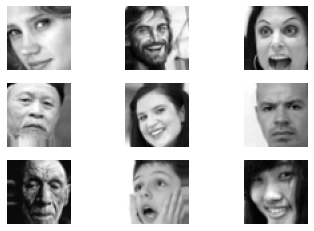

In [16]:
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    for i in range(0, 9): 
        plt.axis('off') 
        plt.subplot(330 + 1 + i) 
        plt.imshow(X_batch[i].reshape(48, 48), cmap=plt.get_cmap('gray'))
    plt.axis('off') 
    plt.show() 
    break

In [17]:
from keras.layers import ZeroPadding2D,Convolution2D,MaxPooling2D,Flatten,Dense,Dropout
from keras.models import Sequential

In [18]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

In [36]:
def FER_Model(input_shape=(48,48,1)):
    # first input model
    visible = Input(shape=input_shape, name='input')
    num_classes = 7
    #the 1-st block
    conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_1')(visible)
    conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_2)
    drop1_1 = Dropout(0.3, name = 'drop1_1')(pool1_1)

    #the 2-nd block
    conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_1')(drop1_1)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)
    conv2_3 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_3')(conv2_2)
    conv2_2 = BatchNormalization()(conv2_3)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_3)
    drop2_1 = Dropout(0.3, name = 'drop2_1')(pool2_1)

#      #the 3-rd block
#     conv3_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_1')(drop2_1)
#     conv3_1 = BatchNormalization()(conv3_1)
#     conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_2')(conv3_1)
#     conv3_2 = BatchNormalization()(conv3_2)
#     conv3_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_3')(conv3_2)
#     conv3_3 = BatchNormalization()(conv3_3)
#     conv3_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_4')(conv3_3)
#     conv3_4 = BatchNormalization()(conv3_4)
#     pool3_1 = MaxPooling2D(pool_size=(2,2), name = 'pool3_1')(conv3_4)
#     drop3_1 = Dropout(0.3, name = 'drop3_1')(pool3_1)

#     #the 4-th block
#     conv4_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_1')(drop3_1)
#     conv4_1 = BatchNormalization()(conv4_1)
#     conv4_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_2')(conv4_1)
#     conv4_2 = BatchNormalization()(conv4_2)
#     conv4_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_3')(conv4_2)
#     conv4_3 = BatchNormalization()(conv4_3)
#     conv4_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_4')(conv4_3)
#     conv4_4 = BatchNormalization()(conv4_4)
#     pool4_1 = MaxPooling2D(pool_size=(2,2), name = 'pool4_1')(conv4_4)
#     drop4_1 = Dropout(0.3, name = 'drop4_1')(pool4_1)
    
#     #the 5-th block
#     conv5_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_1')(drop4_1)
#     conv5_1 = BatchNormalization()(conv5_1)
#     conv5_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_2')(conv5_1)
#     conv5_2 = BatchNormalization()(conv5_2)
#     conv5_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_3')(conv5_2)
#     conv5_3 = BatchNormalization()(conv5_3)
#     conv5_4 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_4')(conv5_3)
#     conv5_3 = BatchNormalization()(conv5_3)
#     pool5_1 = MaxPooling2D(pool_size=(2,2), name = 'pool5_1')(conv5_4)
#     drop5_1 = Dropout(0.3, name = 'drop5_1')(pool5_1)

    #Flatten and output
    flatten = Flatten(name = 'flatten')(drop2_1)
    ouput = Dense(num_classes, activation='softmax', name = 'output')(flatten)

    # create model 
    model = Model(inputs =visible, outputs = ouput)
    # summary layers
    print(model.summary())
    
    return model

In [37]:
model = FER_Model()
opt = Adam(learning_rate=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 1)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_36 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 conv1_2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_37 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 pool1_1 (MaxPooling2D)      (None, 24, 24, 64)        0   

In [22]:
from keras.callbacks import ModelCheckpoint
filepath="weights_min_loss.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [38]:
num_epochs = 50 
history = model.fit(train_flow, 
                    epochs=num_epochs,batch_size=500)

Epoch 1/50
449/449 [==============================] - 654s 1s/step - loss: 2.0857 - accuracy: 0.2475
Epoch 2/50
449/449 [==============================] - 628s 1s/step - loss: 1.7703 - accuracy: 0.3041
Epoch 3/50
 30/449 [=>............................] - ETA: 9:02 - loss: 1.7070 - accuracy: 0.3323

KeyboardInterrupt: 

In [29]:
train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.figure()

KeyError: 'val_loss'

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

In [33]:
loss = model.evaluate(X_test/255., y_test) 
print("Test Loss " + str(loss[0]))
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 7s 57ms/step - loss: 1.3008 - accuracy: 0.5213
Test Loss 1.3007793426513672
Test Acc: 0.5213151574134827


In [34]:
model.save('Fer2013.h5')

In [35]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
